In [9]:
import argparse
import random
from collections import deque

import json
import os.path
import time

from keras import initializers
from keras.initializers import normal, identity
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD , Adam
import tensorflow as tf

In [2]:
from Quarto import *

In [6]:
GAMMA = 0.99 # decay rate of past observations
OFFSET = 0  #number of oservation already done
OBSERVATION = 1000 + OFFSET # timesteps to observe before training
EXPLORE = 3000000. # frames over which to anneal epsilon
EPOCHS = 15000
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 100000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
LEARNING_RATE = 1e-4
ALPHA = 0.6
BETA = 0.4

In [7]:
#We go to training mode
OBSERVE = OBSERVATION

epsilon = INITIAL_EPSILON
if OFFSET:
    for o in range(OFFSET):
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE


from keras.utils import plot_model

def build_model():
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, (2,3), strides=(1, 1), input_shape=(4,16,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (2,3), strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(1))

    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss=quarto_loss.prioritization_loss,optimizer=adam)

    #plot_model(model,show_shapes=True, to_file='model.png')
    print("We finish building the model")
    return model


model = build_model()
print ("Now we load weight")
if os.path.isfile("output/model.h5"):
    model.load_weights("output/model.h5")
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss=quarto_loss.prioritization_loss,optimizer=adam)
    print ("Weight load successfully")

# In[5]:


def select_actions(status, rand=True):
    #getting the available actions
    actions= status.get_available_actions()
    image = None
    if (len(actions) == 0):
        return [], None
    #choose an action epsilon greedy
    if rand and random.random() <= epsilon:
       # print("----------Random Action----------")
        a_index = random.randrange(len(actions))
        image = status.get_action_image(actions[a_index])
        #show_action_image(image)
    else:
        a_images_t = status.get_action_images(actions)
        a_index = np.argmax(model.predict_on_batch(a_images_t))
        image = a_images_t[a_index]
    return actions[a_index] , image



Now we build the model
We finish building the model
Now we load weight
Weight load successfully


In [8]:
rewards = []
pieces = []
losses = []

replay_memory = Experience(REPLAY_MEMORY, BATCH, ALPHA)
#Initial status
s_t0 = get_initial_status()
a_t0,im_t0 = select_actions(s_t0)
t = OFFSET
while(t< EPOCHS +1):
    loss = 0
    r_t = 0
    deltat_train = 0
    deltat_prepare_train = 0
    n_images_train = 0

    #We reduced the epsilon gradually
    if epsilon > FINAL_EPSILON and t > OBSERVE:
        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

    # Now we need to get the answer action and final status
    s_t1, win, win_r = s_t0.get_new_status(a_t0)
    if win:
        #Increasing of 100 the reward
        r_t = win_r +100
        #saving win status
        replay_memory.add((s_t0, a_t0, im_t0, r_t, s_t1, win), 100000)
        #restarting cleaning status
        s_t0 = get_initial_status()
        a_t0, im_t0 = select_actions(s_t0)
        #print("WIN! Reward: {}".format(win_r))
        #show(s_t1[0])

    else:
        #continue with the answer from enemy
        a_t1, im_t1 = select_actions(s_t1)

        if(len(a_t1) == 0):
            #print("No more moves")
            # reset the game because we are stucks
            s_t0 = get_initial_status()
            a_t0, im_t0 = select_actions(s_t0)
            continue

        #get final state
        s_t2, win_e, win_e_r = s_t1.get_new_status(a_t1)
        r_t = s_t0.get_transition_reward(a_t0, a_t1)
        if win_e:
            #reward is decreased of 100
            r_t -= 100
            # this will be analyzed in the next turn
            #print("WIN of ENEMY! Reward: {}".format(r_t))

        # we save the state in the replay memory
        replay_memory.add((s_t0, a_t0, im_t0, r_t, s_t2, win),100000)
        # to the next state
        s_t0 = s_t1
        a_t0 = a_t1
        im_t0 = im_t1


    #only train if done observing
    if t > OBSERVE:
        ttrain1 = time.time()
        #getting stuff for experience replay
        minibatch, weights, indices = replay_memory.select(BETA)
        #setting the weights for the loss function
        quarto_loss.weights = weights
        #sample a minibatch to train on
        inputs = np.zeros((BATCH, 4,16,3))
        targets = np.zeros((BATCH))
        new_priorities = []
        #Now we do the experience replay
        for i in range(BATCH):
            ttrain_j1 = time.time()
            ttrain_j2 = 0
            ttrain_j3 = 0            
            state_t = minibatch[i][0]
            action_t = minibatch[i][1]
            image_t = minibatch[i][2]
            reward_t = minibatch[i][3]
            state_t1 = minibatch[i][4]
            terminal = minibatch[i][5]
            
            # Saving the action image of the first action as input
            inputs[i:i + 1] = image_t
            #Q_sa status
            Q_sa = float(model.predict(image_t.reshape(1,4,16,3))[0])
            #rewards.append(reward_t)
            #pieces.append(state_t.get_num_used_pieces())

            # Getting all the possible action in the final state
            Q_sa_max = 0
            if terminal:
                Q_sa_max = reward_t
                ttrain_j2 = time.time()
                ttrain_j3 = ttrain_j2
            else:
                final_actions= state_t1.get_available_actions()
                if (len(final_actions)==0):
                    #it is the final action
                    Q_sa_max = reward_t
                    ttrain_j2 = time.time()
                    ttrain_j3 = ttrain_j2
                else:
                    n_images_train+=len(final_actions)
                    a_images_t1 = state_t1.get_action_images(final_actions)
                    ttrain_j2 = time.time()
                    Q_sa_next = np.max(model.predict_on_batch(a_images_t1))
                    ttrain_j3 = time.time()
                    Q_sa_max = reward_t + GAMMA * Q_sa_next
            
            #Saving target
            targets[i:i+1] = Q_sa_max
            
            #operations for the experience replay
            td_error = (Q_sa_max - Q_sa)**2
            #print("TD error: {} | Q_sa: {} | Q_target: {}".format(td_error, Q_sa, Q_sa_max))
            new_priorities.append(td_error)
            
            deltat_prepare_train += ttrain_j2 - ttrain_j1
            deltat_train += ttrain_j3 - ttrain_j2
        #backpropagation training
        ttrain2 = time.time()
        loss += model.train_on_batch(inputs, targets)
        ttrain3 = time.time()
        deltat_train += ttrain3- ttrain2
        
        #update priorities in experience replay component
        replay_memory.priority_update(indices, new_priorities)

    #going to the next epoch. The action_t0 and state_t0 are already setted
    t+=1
     # save progress every 10000 iterations
    if t % 1000 == 0:
        print("Now we save model")
        model.save_weights("output/model.h5", overwrite=True)
        with open("output/losses.txt", "w") as outfile:
            outfile.write("\n".join(losses))

    # print info
    if (t > OBSERVE +1):
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"
        if t% 10 == 0:
            print("Epoch {0:d} | N.images {1:>4d} | TP {2:>4.2f} | TT {3:>4.2f} | Reward {4:>4d} | Loss {5:>8.3f}".
                 format(t,n_images_train, deltat_prepare_train,deltat_train, r_t , loss))
        losses.append(str(loss))
        
        
    elif (t <= OBSERVE) and t%100 == 0:
         print("Epoch {0:d} | N.images {1:>4d} | TP {2:>4.2f} | TT {3:>4.2f} | Reward {4:>4d} | Loss {5:>8.3f}".
             format(t,n_images_train, deltat_prepare_train,deltat_train, r_t , loss))


Epoch 100 | N.images    0 | TP 0.00 | TT 0.00 | Reward  -36 | Loss    0.000
Epoch 200 | N.images    0 | TP 0.00 | TT 0.00 | Reward -112 | Loss    0.000
Epoch 300 | N.images    0 | TP 0.00 | TT 0.00 | Reward   20 | Loss    0.000
Epoch 400 | N.images    0 | TP 0.00 | TT 0.00 | Reward   68 | Loss    0.000
Epoch 500 | N.images    0 | TP 0.00 | TT 0.00 | Reward    0 | Loss    0.000
Epoch 600 | N.images    0 | TP 0.00 | TT 0.00 | Reward    0 | Loss    0.000
Epoch 700 | N.images    0 | TP 0.00 | TT 0.00 | Reward  -24 | Loss    0.000
Epoch 800 | N.images    0 | TP 0.00 | TT 0.00 | Reward   22 | Loss    0.000
Epoch 900 | N.images    0 | TP 0.00 | TT 0.00 | Reward   46 | Loss    0.000
Now we save model
Epoch 1000 | N.images    0 | TP 0.00 | TT 0.00 | Reward -138 | Loss    0.000
Epoch 1010 | N.images 2674 | TP 0.17 | TT 0.22 | Reward   66 | Loss 5427407.500
Epoch 1020 | N.images 2936 | TP 0.18 | TT 0.24 | Reward  -22 | Loss 3485382.000
Epoch 1030 | N.images 2758 | TP 0.17 | TT 0.22 | Reward  133 

Epoch 1940 | N.images 2160 | TP 0.14 | TT 0.18 | Reward  242 | Loss 5814512.000
Epoch 1950 | N.images 2746 | TP 0.17 | TT 0.24 | Reward  -24 | Loss 6433276.500
Epoch 1960 | N.images 3056 | TP 0.19 | TT 0.25 | Reward  -42 | Loss 5286784.500
Epoch 1970 | N.images 2542 | TP 0.16 | TT 0.21 | Reward    0 | Loss 7245184.000
Epoch 1980 | N.images 2620 | TP 0.16 | TT 0.22 | Reward   16 | Loss 7521251.000
Epoch 1990 | N.images 2524 | TP 0.16 | TT 0.21 | Reward   16 | Loss 6568791.500
Now we save model
Epoch 2000 | N.images 2388 | TP 0.15 | TT 0.21 | Reward  -22 | Loss 5695202.000
Epoch 2010 | N.images 2114 | TP 0.13 | TT 0.18 | Reward   -6 | Loss 4531933.500
Epoch 2020 | N.images 2616 | TP 0.16 | TT 0.22 | Reward  -12 | Loss 5899090.000
Epoch 2030 | N.images 2608 | TP 0.16 | TT 0.21 | Reward  -82 | Loss 5120144.500
Epoch 2040 | N.images 2380 | TP 0.15 | TT 0.20 | Reward  -74 | Loss 5798172.500
Epoch 2050 | N.images 1852 | TP 0.12 | TT 0.16 | Reward    8 | Loss 6897864.500
Epoch 2060 | N.images 

Epoch 2970 | N.images 2384 | TP 0.15 | TT 0.20 | Reward   -6 | Loss 3791896.500
Epoch 2980 | N.images 2256 | TP 0.14 | TT 0.19 | Reward  126 | Loss 4975169.500
Epoch 2990 | N.images 2462 | TP 0.16 | TT 0.22 | Reward -112 | Loss 3662466.000
Now we save model
Epoch 3000 | N.images 2850 | TP 0.22 | TT 0.33 | Reward    0 | Loss 4529323.500
Epoch 3010 | N.images 3180 | TP 0.19 | TT 0.26 | Reward    0 | Loss 5216915.500
Epoch 3020 | N.images 2580 | TP 0.16 | TT 0.21 | Reward   73 | Loss 4285524.000
Epoch 3030 | N.images 2768 | TP 0.18 | TT 0.23 | Reward  -12 | Loss 4679777.500
Epoch 3040 | N.images 3082 | TP 0.18 | TT 0.24 | Reward  -22 | Loss 2887802.250
Epoch 3050 | N.images 2810 | TP 0.17 | TT 0.23 | Reward   -8 | Loss 6716531.500
Epoch 3060 | N.images 2468 | TP 0.15 | TT 0.20 | Reward    0 | Loss 7352147.500
Epoch 3070 | N.images 2920 | TP 0.18 | TT 0.23 | Reward  -96 | Loss 4630680.500
Epoch 3080 | N.images 2696 | TP 0.16 | TT 0.23 | Reward    0 | Loss 6263703.500
Epoch 3090 | N.images 

Now we save model
Epoch 4000 | N.images 2166 | TP 0.14 | TT 0.19 | Reward    0 | Loss 4404012.500
Epoch 4010 | N.images 2342 | TP 0.14 | TT 0.20 | Reward    0 | Loss 4152822.250
Epoch 4020 | N.images 2562 | TP 0.16 | TT 0.21 | Reward   -8 | Loss 3223810.250
Epoch 4030 | N.images 2094 | TP 0.13 | TT 0.19 | Reward  -56 | Loss 2737866.250
Epoch 4040 | N.images 2556 | TP 0.16 | TT 0.21 | Reward  -12 | Loss 3564547.750
Epoch 4050 | N.images 2270 | TP 0.14 | TT 0.19 | Reward  -22 | Loss 4470955.500
Epoch 4060 | N.images 2698 | TP 0.16 | TT 0.22 | Reward   14 | Loss 3458549.750
Epoch 4070 | N.images 2710 | TP 0.16 | TT 0.22 | Reward    4 | Loss 3717571.750
Epoch 4080 | N.images 2920 | TP 0.18 | TT 0.24 | Reward  -86 | Loss 4108094.000
Epoch 4090 | N.images 2596 | TP 0.16 | TT 0.22 | Reward    0 | Loss 3384528.250
Epoch 4100 | N.images 2486 | TP 0.15 | TT 0.21 | Reward  -66 | Loss 2155905.750
Epoch 4110 | N.images 2532 | TP 0.15 | TT 0.21 | Reward  -73 | Loss 2934336.250
Epoch 4120 | N.images 

Epoch 5020 | N.images 2984 | TP 0.18 | TT 0.26 | Reward  -36 | Loss 3997096.250
Epoch 5030 | N.images 2414 | TP 0.17 | TT 0.23 | Reward  -10 | Loss 3752464.500
Epoch 5040 | N.images 2136 | TP 0.14 | TT 0.20 | Reward  198 | Loss 3610864.000
Epoch 5050 | N.images 2826 | TP 0.24 | TT 0.34 | Reward -111 | Loss 2945536.500
Epoch 5060 | N.images 1948 | TP 0.12 | TT 0.17 | Reward  -46 | Loss 3273831.750
Epoch 5070 | N.images 2756 | TP 0.17 | TT 0.22 | Reward -112 | Loss 3429460.500
Epoch 5080 | N.images 2454 | TP 0.15 | TT 0.21 | Reward  -29 | Loss 4100676.000
Epoch 5090 | N.images 3136 | TP 0.20 | TT 0.27 | Reward -125 | Loss 6194863.500
Epoch 5100 | N.images 2796 | TP 0.18 | TT 0.24 | Reward  -36 | Loss 3690556.000
Epoch 5110 | N.images 2560 | TP 0.16 | TT 0.21 | Reward  -22 | Loss 3451854.250
Epoch 5120 | N.images 2390 | TP 0.15 | TT 0.21 | Reward   -2 | Loss 3487626.250
Epoch 5130 | N.images 1978 | TP 0.13 | TT 0.17 | Reward   14 | Loss 3468388.250
Epoch 5140 | N.images 1974 | TP 0.13 | T

KeyboardInterrupt: 

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

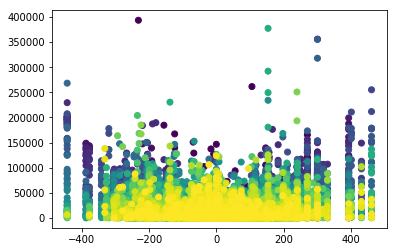

63968


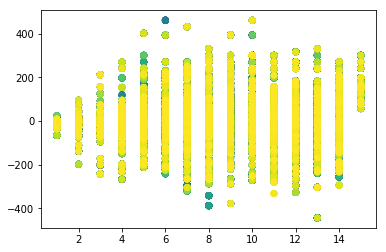

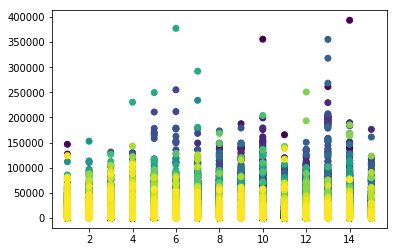

In [16]:
plt.scatter(rewards, losses, c=range(len(losses)))
plt.show()
print(len(rewards))

plt.scatter(pieces,rewards,c=range(len(losses)))
plt.show()

plt.scatter(pieces, losses,c=range(len(losses)))
plt.show()

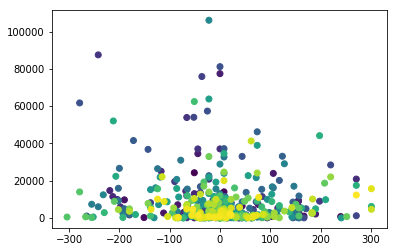

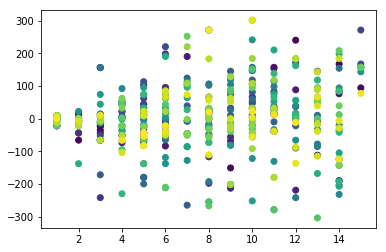

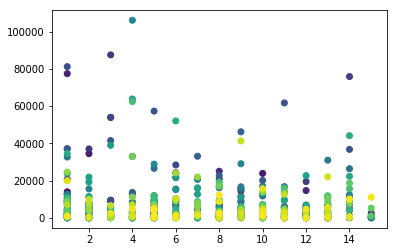

In [17]:
plt.scatter(rewards[-500:], losses[-500:], c=range(500))
plt.show()

plt.scatter(pieces[-500:],rewards[-500:],  c=range(500))
plt.show()

plt.scatter(pieces[-500:], losses[-500:], c=range(500))
plt.show()